In [43]:
import s3_helper
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt

In [44]:
BUCKET_ISO = 'virtual-regatta-isochrones'
USER_ID = '5f8f047a52e859ef03117e71'
RACE = '440'
ISOS_NUMBER = 5
R2_MIN = 0.8
WP_NUMBER = 20

In [45]:
def get_latest_isos_keys(bucket, user_id, race, number_of_isos):
    latest_folder = s3_helper.get_latest_folder(bucket, f'live/{user_id}/{race}/')
    all_files = s3_helper.get_all_files(bucket, f'live/{user_id}/{race}/{latest_folder}')
    all_files_sorted = sorted(all_files, key=lambda k: k['LastModified'], reverse=True) 
    all_keys = [x['Key'] for x in all_files_sorted]
    print(f'Found {len(all_keys)} isochrones files')

    if len(all_keys) < number_of_isos:
        print(f'Found less isochrones files than the threshold: {number_of_isos}, getting files from yesterday')
        second_latest_folder = s3_helper.get_latest_folder(bucket, f'live/{user_id}/{race}/', start_days_in_past=1)
        all_files = s3_helper.get_all_files(bucket, f'live/{user_id}/{race}/{second_latest_folder}')
        all_files_sorted = sorted(all_files, key=lambda k: k['LastModified'], reverse=True) 
        all_keys += [x['Key'] for x in all_files_sorted]
        print(f'Now have a total of {len(all_keys)} files')

    if len(all_keys) > number_of_isos:
        all_keys = all_keys[0:number_of_isos]
        print(f'Truncated the number of files to only consider the first {number_of_isos} first ones')
    return all_keys

In [46]:
isos_keys = get_latest_isos_keys(BUCKET_ISO, USER_ID, RACE, ISOS_NUMBER)
isos_wp = []
for key in isos_keys:
    isos_wp.append(s3_helper.get_waypoints(BUCKET_ISO, key))


Found 29 isochrones files
Truncated the number of files to only consider the first 5 first ones
Isochrones file: virtual-regatta-isochrones/live/5f8f047a52e859ef03117e71/440/20201215/14-25-44-438188.json
Isochrones file: virtual-regatta-isochrones/live/5f8f047a52e859ef03117e71/440/20201215/13-55-47-27954.json
Isochrones file: virtual-regatta-isochrones/live/5f8f047a52e859ef03117e71/440/20201215/13-25-50-574913.json
Isochrones file: virtual-regatta-isochrones/live/5f8f047a52e859ef03117e71/440/20201215/12-55-44-310267.json
Isochrones file: virtual-regatta-isochrones/live/5f8f047a52e859ef03117e71/440/20201215/12-25-48-606312.json


In [47]:
def get_x_coords(waypoints):
    x_coords = []
    shift = 0
    for wp in waypoints:
        x = wp[0]
        if x < 0 and abs(x) > shift:            
            shift += abs(x)
            print(f'Negative coordinate, new shift value: {shift}')
        x += shift * 2
        x_coords.append(x)
    return x_coords

def get_y_coords(waypoints):
    y_coords = []
    for wp in waypoints:
        y = wp[1]
        y_coords.append(y)
    return y_coords

In [48]:
svr_list = []
isos_x = []
isos_y = []
init_x = None
init_shift = 0
isos_wp.reverse()
for wp in isos_wp:
    print('-------------------')
    x_coords = get_x_coords(wp[0:WP_NUMBER])    
    y_coords = get_y_coords(wp[0:WP_NUMBER])

    first_x = x_coords[0]
    if init_x is None:        
        init_x = first_x
        print(f'init x: {init_x}')
    else:        
        init_shift = first_x - init_x
        print(f'init shift: {init_shift}')
    x_coords_shift = [a - init_shift for a in x_coords]

    x = np.array(x_coords_shift).reshape(-1, 1)
    y = np.array(y_coords).reshape(-1, 1)    
    regr = svm.SVR()
    regr.fit(x, y)
    r2 = regr.score(x, y)
    print(f'R2: {round(r2,3)}')
    if r2 < R2_MIN:
        print('R2 is lower than the threshold, not keeping this isochrones...')
    else:
        svr_list.append(regr)
        isos_x.append(x)
        isos_y.append(y)

-------------------
init x: 37.635106190836254
R2: 0.808
-------------------
init shift: 0.005629350392247545
R2: 0.834
-------------------
init shift: 0.007918177069939247
R2: 0.867
-------------------
init shift: 0.013624153490155777
R2: 0.863
-------------------
init shift: 0.00464871015809365
R2: 0.839


In [49]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

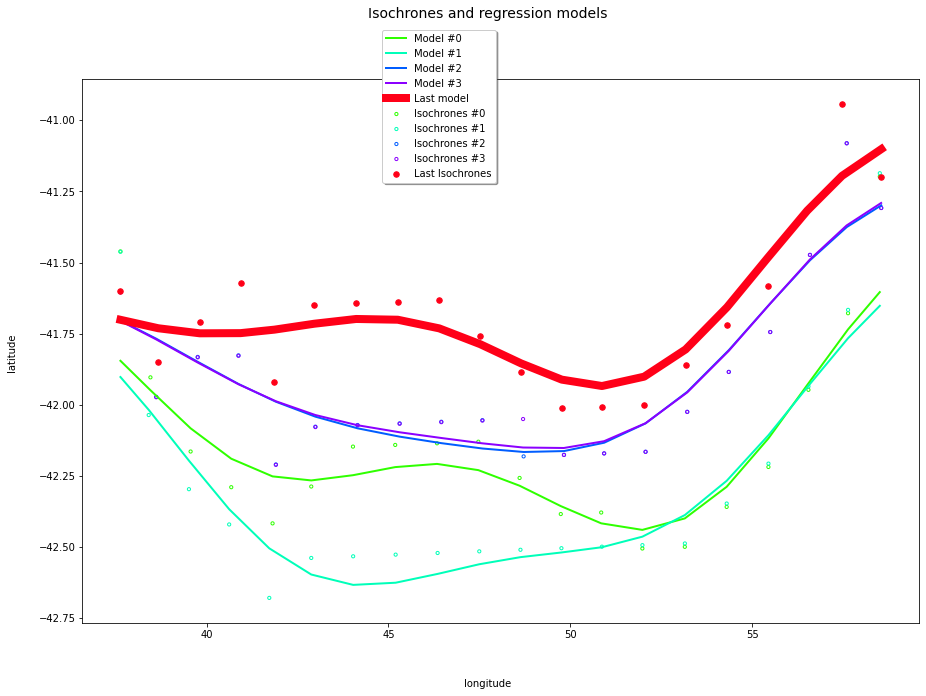

In [50]:
svr_list_copy = [c for c in svr_list]

lw = 2

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
cmap = get_cmap(len(svr_list_copy)*2+4)
for i, svr in enumerate(svr_list_copy[:-1]):
    color = cmap(i*2+4)
    axes.scatter(isos_x[i], isos_y[i], facecolor="none",
                     edgecolor=color, s=10,
                     label=f'Isochrones #{i}')
    
    axes.plot(isos_x[i], svr.fit(isos_x[i], isos_y[i]).predict(isos_x[i]), color=color, lw=lw,
                  label=f'Model #{i}')
    #axes.scatter(x[svr.support_], y[svr.support_], facecolor="none",
    #                 edgecolor=model_color[ix], s=5,
    #                 label='{} support vectors'.format(kernel_label[ix]))
    #axes.scatter(x[np.setdiff1d(np.arange(len(x)), svr.support_)],
    #                 y[np.setdiff1d(np.arange(len(x)), svr.support_)],
    #                 facecolor="none", edgecolor="k", s=5,
    #                 label='other training data')
    
    

color = cmap(len(svr_list_copy)*2+4)
axes.scatter(isos_x[-1], isos_y[-1], facecolor=color,
                     edgecolor=color, s=30,
                     label=f'Last Isochrones')
    
axes.plot(isos_x[-1], svr_list_copy[-1].fit(isos_x[-1], isos_y[-1]).predict(isos_x[-1]), color=color, lw=8,
                  label=f'Last model')    

axes.legend(loc='best', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'longitude', ha='center', va='center')
fig.text(0.06, 0.5, 'latitude', ha='center', va='center', rotation='vertical')
fig.suptitle("Isochrones and regression models", fontsize=14)
plt.show()

In [51]:
latest_svr = svr_list[-1]
#print(latest_svr.support_vectors_)
#print(latest_svr.support_)
#print(latest_svr.dual_coef_)

list_sv_score = []
list_coef_score = []
isos_index = []

for j, svr in enumerate(svr_list[:-1]):
    print('----------------')
    #print(svr.support_vectors_)
    #print(svr.support_)
    #print(svr.dual_coef_)
    sv_score = 0
    coef_score = 0

    common_support = 0
    for i, indice in enumerate(latest_svr.support_):
        if indice in svr.support_:
            svr_index = np.where(np.isclose(svr.support_, indice))
            latest_svr_sv = latest_svr.support_vectors_[i]
            latest_svr_coef = latest_svr.dual_coef_[0][i]
            svr_sv = svr.support_vectors_[svr_index]
            svr_coef = svr.dual_coef_[0][svr_index]
            sv_score += abs(latest_svr_sv - svr_sv)
            coef_score += abs(latest_svr_coef - svr_coef)
            common_support += 1
    if common_support == 0:
        print('No support indice in common')
    else:
        sv_score /= common_support
        coef_score /= common_support
        sv_score = sv_score.tolist()[0][0]
        coef_score = coef_score.tolist()[0]
        list_sv_score.append(sv_score)
        list_coef_score.append(coef_score)
        isos_index.append(j)
    print(f'SV score: {sv_score}  |  Coef score: {coef_score}')


----------------
SV score: 0.07164475504787475  |  Coef score: 0.6480459142376155
----------------
SV score: 0.07162385604265893  |  Coef score: 0.5445096618371013
----------------
SV score: 0.055042100853825104  |  Coef score: 0.0842383287176559
----------------
SV score: 0.05352333624732759  |  Coef score: 0.06895177479822771


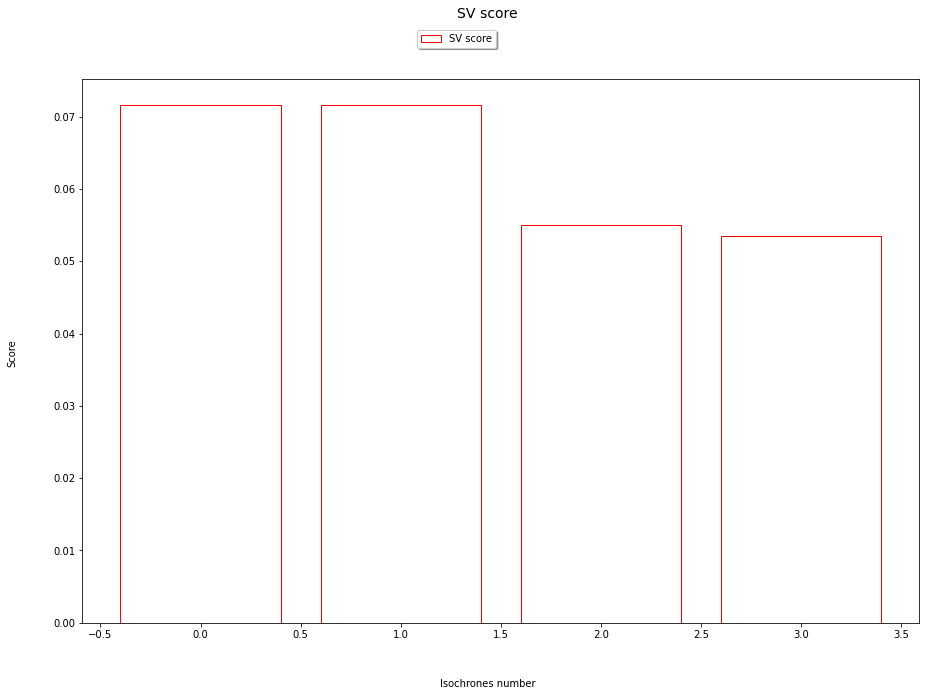

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

axes.bar(isos_index, list_sv_score, facecolor="none",
                     edgecolor='r',
                     label='SV score')
axes.legend(loc='best', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)
    

fig.text(0.5, 0.04, 'Isochrones number', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.suptitle("SV score", fontsize=14)
plt.show()

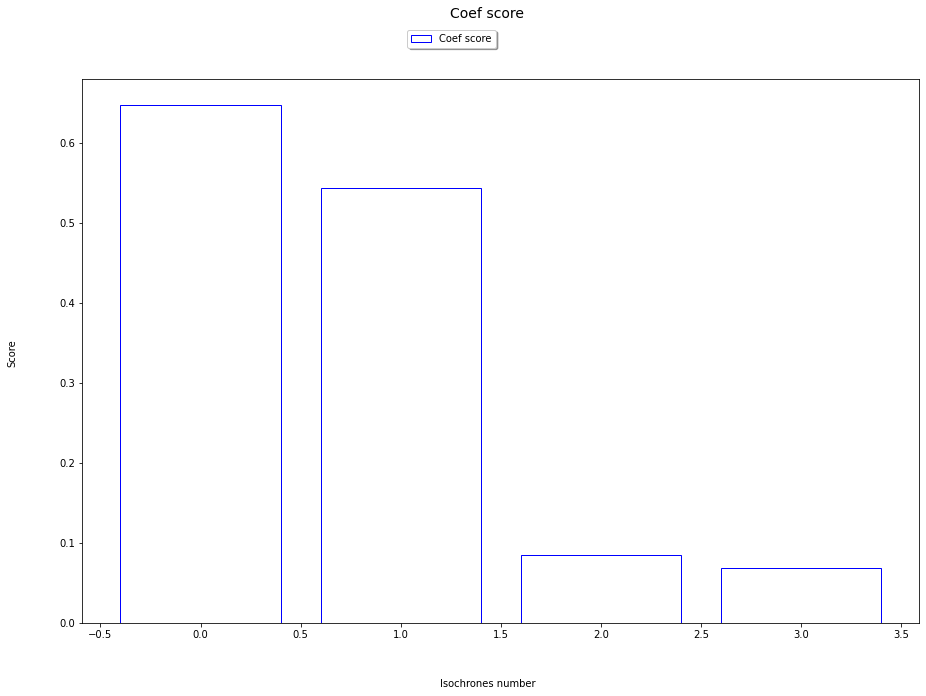

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
axes.bar(isos_index, list_coef_score, facecolor="none",
                     edgecolor='b', 
                     label='Coef score')

axes.legend(loc='best', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)
    

fig.text(0.5, 0.04, 'Isochrones number', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.suptitle("Coef score", fontsize=14)
plt.show()